### What are some ideas Airbnb would likely want to understand?

1. What guests are searching in Dublin?  
2. Which inquiries do hosts tend to accept?  
3. What gaps exist between guest demand and host supply?  
4. Does an indirect combination of data reveal new info?  

The goal is to analyze, understand, visualize, and communicate the demand/supply of the market in Dublin

#### Data Exploration

In [2]:
# first import dependecies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import data from different csv files
# this should be good practice if we have to join them along some column
contacts = pd.read_csv("./data/contacts.tsv", sep="\t")
searches = pd.read_csv("./data/searches.tsv", sep="\t")

In [3]:
# Find % of null values in datasets 
print('Contacts')
print(contacts.isna().sum()/len(contacts), '\n')
print('Searches')
print(searches.isna().sum()/len(searches))

Contacts
id_guest          0.000000
id_host           0.000000
id_listing        0.000000
ts_contact_at     0.000000
ts_reply_at       0.077208
ts_accepted_at    0.536367
ts_booking_at     0.722101
ds_checkin        0.000000
ds_checkout       0.000000
n_guests          0.000000
n_messages        0.000000
dtype: float64 

Searches
ds                      0.000000
id_user                 0.000000
ds_checkin              0.331561
ds_checkout             0.331561
n_searches              0.000000
n_nights                0.331561
n_guests_min            0.000000
n_guests_max            0.000000
origin_country          0.000000
filter_price_min        0.627221
filter_price_max        0.627221
filter_room_types       0.546940
filter_neighborhoods    0.962336
dtype: float64


The neighborhood column in searches returns 96.2336%, which would give any future model trouble learning. 
It's probably a good idea just to drop it

In [5]:
searches = searches.drop(columns=['filter_neighborhoods'])

KeyError: "['filter_neighborhoods'] not found in axis"

In [5]:
#Checking the data types of the columns in the searches dataset
searches.dtypes

ds                    object
id_user               object
ds_checkin            object
ds_checkout           object
n_searches             int64
n_nights             float64
n_guests_min           int64
n_guests_max           int64
origin_country        object
filter_price_min     float64
filter_price_max     float64
filter_room_types     object
dtype: object

The date columns (ds, ds_checkin, ds_checkout) are object types, which can be converted to DateTime for easier manipulation. 

It is insightful to check how soon people want their rooms. 
Calculate it using the difference between the ds (date search) and ds_checkin (date check-in).

Checking its distribution would reveal how soon people start planning their trips. 
This could lead to better business decisions in anticipation of demand

In [6]:
#Manipulation of searches dataset

#Convert date column to datetime data type
searches['ds'] = pd.to_datetime(searches['ds'])
searches['ds_checkin'] = pd.to_datetime(searches['ds_checkin'])
searches['ds_checkout'] = pd.to_datetime(searches['ds_checkout'])

The describe function displays a 8 number summary to understand the distribution of the dataset.  
This is helpful to understand if there are any obvious skewness or outliers in the dataset that could be fixed quickly.


In [7]:
#How soon they want the room
searches['length_preperation'] = searches['ds_checkin'] - searches['ds']

#Describe searches dataset
display(searches.describe())

,n_searches,n_nights,n_guests_min,n_guests_max,filter_price_min,filter_price_max,length_preperation
count,35737.000000,23888.000000,35737.000000,35737.000000,13322.000000,1.332200e+04,23888
mean,9.206565,7.672765,1.742955,2.105857,8.470200,9.019063e+07,51 days 08:11:53.730743469
std,17.348746,21.557614,1.460440,1.817358,53.987679,2.978482e+08,65 days 18:56:19.491940518
min,1.000000,0.000000,1.000000,1.000000,0.000000,9.000000e+00,-1 days +00:00:00
25%,1.000000,2.000000,1.000000,1.000000,0.000000,8.600000e+01,10 days 00:00:00
50%,4.000000,3.000000,1.000000,2.000000,0.000000,1.390000e+02,26 days 00:00:00
75%,10.000000,5.000000,2.000000,2.000000,0.000000,3.010000e+02,67 days 00:00:00
max,448.000000,399.000000,16.000000,16.000000,1250.000000,1.073742e+09,604 days 00:00:00


Describe() reveals # guests is usually 1 or 2.  
since even at 75% the n_guests_min and n_guests_max is 2 and at 25% are 1.  
A safe conclusion is that smaller accommodations are preferred.

It's a good idea to check for skewness b/c most models and diagnostic tests assume normal distribution of data
Skewness is where the distribution of the values leans towards a specific side of the normal distribution.  
Let's calculate it through the Fisher-Pearson coefficient.

In [8]:
#Calculate skewness in searches dataset
display(searches.skew(axis = 0, numeric_only = True, skipna = True))

n_searches           7.509258
n_nights             9.942364
n_guests_min         3.583798
n_guests_max         3.148548
filter_price_min    11.087745
filter_price_max     2.999833
dtype: float64

All numeric columns have a Fisher-Pearson coefficient value greater than 1, meaning a positive skewness. 
There are several techniques such as log transformation to reduce the skewness in data described below  
https://opendatascience.com/transforming-skewed-data-for-machine-learning/

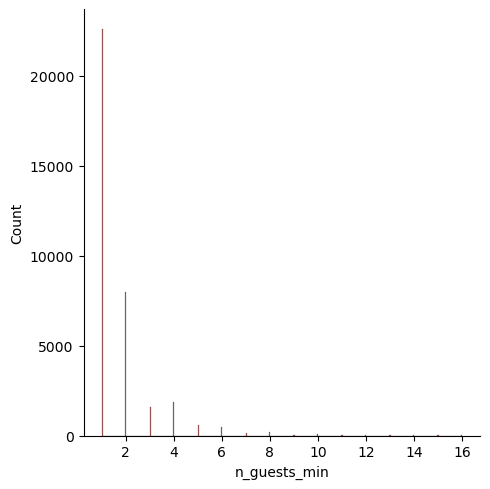

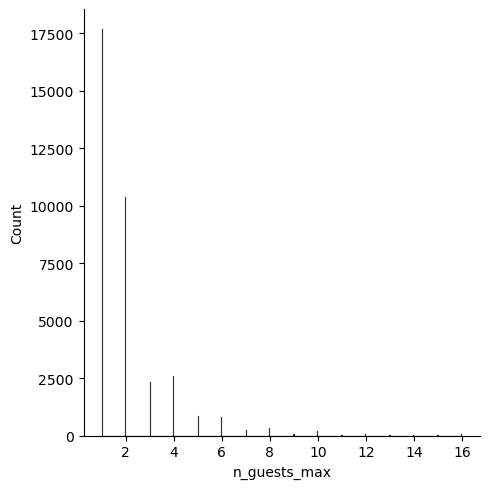

In [9]:
#Distribution plot of n_guests_min and n_guests_max
# Let me practice using seaborn 
sns.displot(searches, x = 'n_guests_min', color = 'brown')
sns.displot(searches, x = 'n_guests_max', color = 'black')
plt.show()

Both have similar distributions with 1 being the most popular option and 2 being the next popular option.  
This leads me to believe smaller accommodations would be a good investment for in Dublin.

Let's check distribution of searches

[[None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None]]

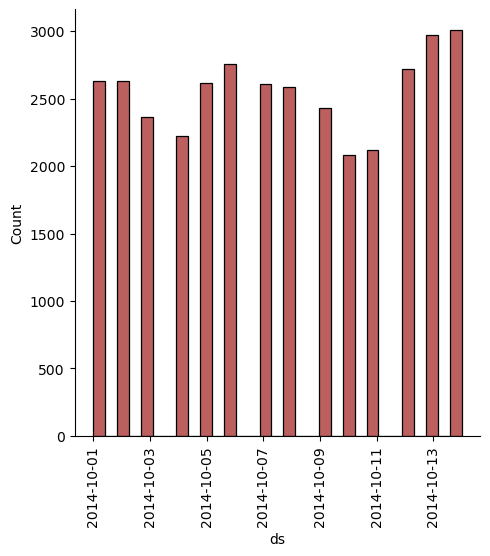

In [14]:
ax = sns.displot(searches, x = 'ds', color = 'brown')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in ax.axes.flat]

Not much to note here

Let's check the distribution of filter_price_max

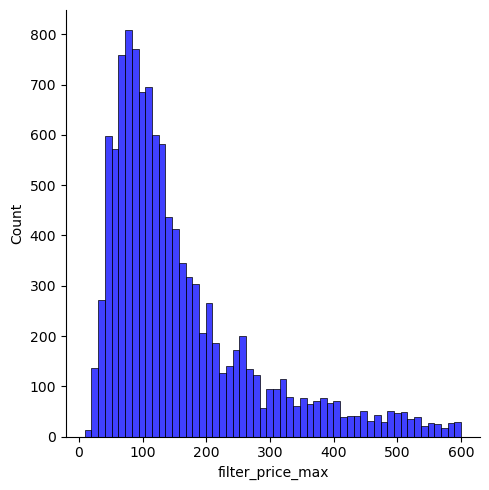

In [16]:
# make the visualization cleaner by removing large outliers
searches_maxprice_removed = searches[searches['filter_price_max'] <= 600]
sns.displot(x=searches_maxprice_removed["filter_price_max"], color = 'blue')
plt.show()

Most search for a room below 200 per night with a peak at 100 per night.  
59% of people searched for rooms between 60 and 130 a night.

Let's calculate how soon people want rooms when booking. First, we have to convert the length_preperation column to the int data type for filtering. After that search for length_preperations less than 100, since only 9.4% of the dataset exists beyond that.

9.396423874415872 % 



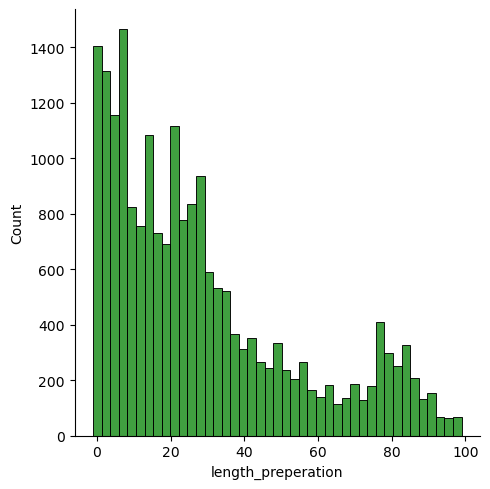

In [13]:
#Distribution of length_preperation of searches

#Percentage of dataset beyond 100 days
distribution = searches["length_preperation"] / np.timedelta64(1, 'D')
print(len(distribution[distribution > 100])/len(distribution)*100, '% \n')
#Remove values beyond 100 days
distribution = distribution[distribution < 100]
#Distribution plot of length_preperation column
sns.displot(x=distribution, color = 'green')
plt.show()

Based on this data, around 37% of people search for a room within 2 weeks

23.7% search for rooms within a week  
13.46% search for rooms between 1-2 weeks  
12.51% search for rooms between 2-3 weeks  

let's find the distribution of the number of nights people want to stay.  
4.74% of the dataset exists beyond 20 days, so let's filter those out for the time being

4.737387021854101 % 



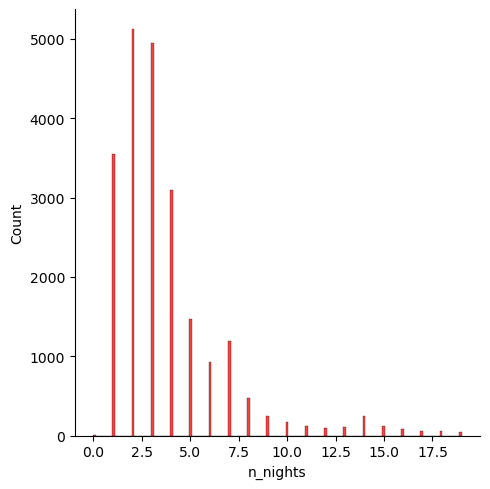

In [17]:
#Distribution of n_nights of searches

#Percentage of dataset beyond 20 nights
print(len(searches[searches['n_nights'] > 20])/len(searches['n_nights'])*100, '% \n')
#Remove n_nights beyond 20 days
searches_within_twenty = searches[searches['n_nights'] < 20]
#Distribution plot of length_preperation column
sns.displot(searches_within_twenty, x='n_nights', color = 'red')
plt.show()

Around 70% of people want to stay between 1-4 days, mostly 2 or 3.  
Stay for more than a week is uncommon at only 15%

Let's check another distribution

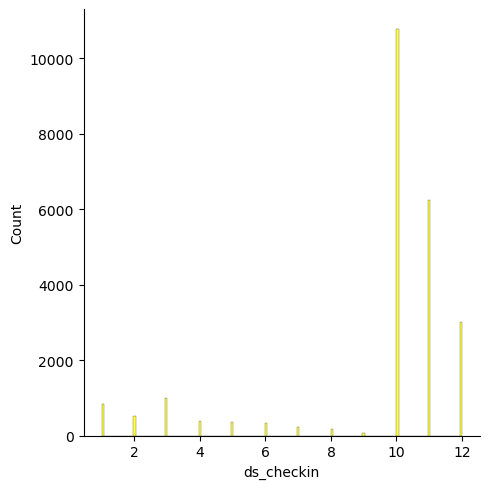

In [18]:
# isolate month from datetime
checkin_month = pd.DatetimeIndex(searches['ds_checkin']).month
#Distribution plot of length_preperation column
sns.displot(checkin_month, color = 'yellow')
plt.show()

83.74% of searches were in the October-December

Breakdown:  
45.05% in October  
26.1% in November  
12.6% in December

In [19]:
#Types of rooms searched for
searches['filter_room_types'].unique()[0:15]

array([',Entire home/apt,Entire home/apt,Private room,Private room', nan,
       ',Entire home/apt',
       'Entire home/apt,Entire home/apt,Private room,Private room',
       'Entire home/apt', ',Shared room,Private room',
       'Entire home/apt,Private room,Shared room,Private room,Shared room',
       'Private room', 'Entire home/apt,Private room', ',Private room',
       ',Entire home/apt,Private room',
       ',Entire home/apt,Private room,Private room',
       'Entire home/apt,Private room,Shared room',
       ',Entire home/apt,Entire home/apt,Private room',
       ',Entire home/apt,Entire home/apt,Shared room,Shared room'],
      dtype=object)

Most of the room types requested were entire home/apt and private rooms sometimes shared rooms. 
If given more time, I would have cleaned this column since most filter values are repeated within the same cell.

In [20]:
#Find top 15 countries where searches originate from

# simple group by and count
search_origin = searches.groupby("origin_country").agg({'origin_country' : 'count'})
search_origin.columns = ['count']
# sort it descendingly and return top 15
search_origin = search_origin.sort_values('count', ascending = False)
search_origin.nlargest(15, 'count')

,count
origin_country,
IE,6608
US,5811
GB,4832
FR,3444
IT,2333
DE,2170
ES,1759
CA,1085
AU,962


Ireland, the US, and Great Britain comprise 48% of searches.  

### Contacts Dataset

In [19]:
#Datatypes of contacts dataset
contacts.dtypes

id_guest          object
id_host           object
id_listing        object
ts_contact_at     object
ts_reply_at       object
ts_accepted_at    object
ts_booking_at     object
ds_checkin        object
ds_checkout       object
n_guests           int64
n_messages         int64
dtype: object

In [21]:
#Convert date columns to datetime data type 
contacts['ts_contact_at'] = pd.to_datetime(contacts['ts_contact_at'])
contacts['ts_reply_at'] = pd.to_datetime(contacts['ts_reply_at'])
contacts['ts_accepted_at'] = pd.to_datetime(contacts['ts_accepted_at'])
contacts['ts_booking_at'] = pd.to_datetime(contacts['ts_booking_at'])
contacts['ds_checkin'] = pd.to_datetime(contacts['ds_checkin'])
contacts['ds_checkout'] = pd.to_datetime(contacts['ds_checkout'])
contacts['accepted'] = np.where(np.isnan(contacts['ts_accepted_at']), False, True)
# calculation
contacts['length_stay'] = contacts['ds_checkout'] - contacts['ds_checkin']

#Understand dataset with describe function
display(contacts.describe())

,n_guests,n_messages,length_stay
count,7823.000000,7823.000000,7823
mean,2.422600,6.319954,5 days 19:25:32.864629937
std,1.617347,6.472827,14 days 23:45:24.447710564
min,1.000000,1.000000,1 days 00:00:00
25%,1.000000,2.000000,2 days 00:00:00
50%,2.000000,4.000000,3 days 00:00:00
75%,3.000000,8.000000,5 days 00:00:00
max,16.000000,102.000000,334 days 00:00:00


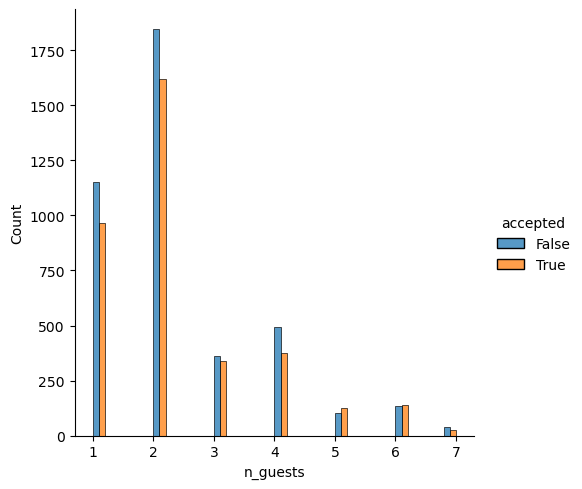

In [22]:
#Number of guests stayed
contacts_less8 = contacts[contacts['n_guests'] < 8]
sns.displot(contacts_less8, x = 'n_guests', hue = 'accepted', multiple="dodge")
plt.show()

2 guests is the most popular option to book, but 1 guest is the most popularly searched option.  
This discrepancy leads me to believe there is a lack of supply of viable single guest rooms.

I was also wondering how many acceptance actually is converted into booking the room.

In [24]:
#Conversion rate from accepting to booking
contacts['ts_booking_at'].count()/contacts['ts_accepted_at'].count()

0.5993934381031155

In [26]:
#Merge datasets for more analysis
merged_datasets = contacts.merge(searches, left_on='id_guest', right_on='id_user')

Let's define a function that will separate price ranges

In [28]:
#Classify dataset based on filter_price_max
def label_price (row):
    if (row['filter_price_max'] >= 0) & (row['filter_price_max'] < 100):
        return '0-100'
    elif (row['filter_price_max'] >= 100) & (row['filter_price_max'] < 200):
        return '100-200'
    elif (row['filter_price_max'] >= 200) & (row['filter_price_max'] < 300):
        return '200-300' 
    elif (row['filter_price_max'] >= 300) & (row['filter_price_max'] < 400):
        return '300-400'
    elif (row['filter_price_max'] >= 400) & (row['filter_price_max'] < 500):
        return '400-500'
    elif (row['filter_price_max'] >= 500) & (row['filter_price_max'] < 600):
        return '500-600'
    else:
        return '600+'
# apply to dataset
merged_datasets['classification_max_price'] = merged_datasets.apply(lambda row: label_price(row), axis=1)
# return mean for each section
merged_datasets.groupby('classification_max_price').agg({'accepted': 'mean'})

,accepted
classification_max_price,
0-100,0.411160
100-200,0.430308
200-300,0.431149
300-400,0.450488
400-500,0.485549
500-600,0.422297
600+,0.433122


In [29]:
#Find the acceptance rate by country
# filter needed columns
dataset_country = merged_datasets[['origin_country', 'accepted']]
#Find acceptance count by country and accepted
accepted_count = dataset_country.groupby(['origin_country', 'accepted']).agg({'origin_country':'count'})
accepted_count.columns = ['count_accepted']

#Find acceptance count by country
country_count = dataset_country.groupby(['origin_country']).agg({'origin_country':'count'})
country_count.columns = ['count_country']

#Merge datasets for easier manipulation 
acceptance_country = pd.merge(dataset_country, accepted_count,  how='left', on=['origin_country','accepted']) #Merge accepted count
acceptance_country = acceptance_country.drop_duplicates()
# Merge total country count
acceptance_country = pd.merge(acceptance_country, country_count, how='left', on=['origin_country']) 
acceptance_country = acceptance_country.sort_values(['count_country', 'accepted'], ascending = [False, True])
# 100 is used so there is a good amount of data to make assumptions
acceptance_country = acceptance_country[acceptance_country['count_country'] >= 100]
# remove where accepted is false
acceptance_country = acceptance_country[acceptance_country['accepted'] == True]
# Divide count_accepted column by count_country column to find acceptance rate by country
acceptance_country['acceptance_rate'] = acceptance_country['count_accepted']/acceptance_country['count_country']
acceptance_country.sort_values(['acceptance_rate'], ascending = True)


,origin_country,accepted,count_accepted,count_country,acceptance_rate
73,IN,True,138,874,0.157895
55,HR,True,159,530,0.300000
72,AT,True,83,239,0.347280
54,RU,True,83,239,0.347280
11,IT,True,1183,3137,0.377112
100,AE,True,59,154,0.383117
0,CA,True,407,993,0.409869
13,IE,True,1217,2951,0.412403
24,ES,True,794,1914,0.414838
49,RO,True,50,118,0.423729


India only has the lowest acceptance rate of 15%, which is half of the second lowest

Denmark has the highest acceptance rate but low application numbers. Increasing marketing in this country could increase demand, driving the market

More investigation needed!